In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import PchipInterpolator, CubicSpline, UnivariateSpline
from scipy.optimize import minimize_scalar, differential_evolution

import time

from fastprogress import progress_bar

from scipy.linalg import qr, qr_insert

from scipy.sparse.linalg import LinearOperator

import scipy.sparse.linalg as splinalg
import scipy.sparse as sps

import pickle

import math
import shutil

#from easygsvd import gsvd as gsvd_func
#from easygsvd import random_rank_matrix

import jlinops

import os
import sys
sys.path.append("../..")
sys.path.append("..")
sys.path.append("../../..")

from scipy.sparse.linalg import aslinearoperator

from pytikhonov import lcorner, TikhonovFamily, discrepancy_principle, lcorner, find_lcurve_corner, plot_rdata, picard_plot, gcvmin, all_regparam_methods
from pytikhonov import rand_discrepancy_principle, rand_lcurve, rand_lcorner, rand_gcvmin
from pytikhonov import plot_gcv, plot_dp, plot_lcorner, plot_all_methods, picard_plot
from pytikhonov import golub_kahan
from pytikhonov import estimate_noise_variance, plot_monitoring_function

from pytikhonov import ProjectedTikhonovFamily

In [6]:
burgers_data = np.load("exact_solution.npy").T
grid_shape = burgers_data.shape

In [7]:
import numpy as np
from scipy.sparse.linalg import LinearOperator, aslinearoperator

def vstack_linops(ops):
    """
    Vertically stack a list of LinearOperators.

    Result is like:
        [ A ]
        [ B ]
        [ C ]
    """
    # Convert everything to LinearOperator
    ops = [aslinearoperator(op) for op in ops]

    # All must have same number of columns
    ncols = ops[0].shape[1]
    for op in ops:
        if op.shape[1] != ncols:
            raise ValueError("All operators must have the same number of columns")

    row_sizes = [op.shape[0] for op in ops]
    m_total = sum(row_sizes)

    # Infer dtype
    dtype = np.result_type(*[op.dtype for op in ops])

    def matvec(x):
        # Stack the outputs of each op
        ys = [op @ x for op in ops]
        return np.concatenate(ys)

    def rmatvec(y):
        # Split y and apply adjoints, then add
        parts = []
        offset = 0
        for op, m in zip(ops, row_sizes):
            yi = y[offset:offset + m]
            parts.append(op.rmatvec(yi))
            offset += m
        return sum(parts)

    return LinearOperator(
        shape=(m_total, ncols),
        matvec=matvec,
        rmatvec=rmatvec,
        dtype=dtype,
    )


# Set up the toy problem

In [8]:
burgers_data = np.load("exact_solution.npy").T[:,:800]
grid_shape = burgers_data.shape
n_space, n_time = grid_shape
xtrue = burgers_data.flatten()
N = len(xtrue)

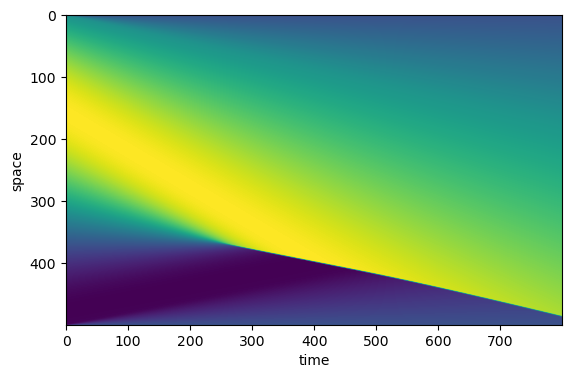

In [54]:
plt.imshow(burgers_data)
plt.xlabel("time")
plt.ylabel("space")
plt.show()

In [10]:
n_skip_space = 7
P1d = np.eye(burgers_data.shape[0])[::n_skip_space,:]

# Build the 2D operator

def matvec(x):
    """Compute y = A x."""
    tmp = x.reshape(grid_shape)
    tmp = P1d @ tmp
    return tmp.flatten()

def rmatvec(x):
    """Compute y = A^T x."""
    # x has shape (P1d.shape[0] * grid_shape[1],)
    tmp = x.reshape(P1d.shape[0], grid_shape[1])   # (Nx_sub, Ny)
    tmp = P1d.T @ tmp                              # (Nx_full, Ny)
    return tmp.flatten()                           # length = Nx_full * Ny


A = LinearOperator(
    shape=(P1d.shape[0]*n_time, N),
    matvec=matvec,
    rmatvec=rmatvec,
    dtype=float,
)


In [11]:
n_space, n_time = grid_shape
L1d_space, _ = jlinops.first_order_derivative_1d(n_space)
L1d_time, _ = jlinops.first_order_derivative_1d(n_time)
Lspace = sps.kron(L1d_space, sps.eye(n_time))
Ltime = sps.kron(sps.eye(n_space), L1d_time)
L = sps.vstack([Lspace, Ltime])

In [34]:
noise_sigma = 1e-1
noise_var = noise_sigma**2
btrue = A @ xtrue
M = len(btrue)
b = btrue + noise_sigma*np.random.normal(size=M)
backproj = (A.T @ b).reshape(grid_shape)

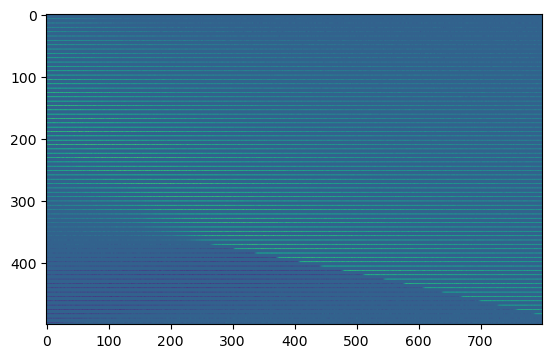

In [43]:
plt.imshow(backproj)
plt.show()

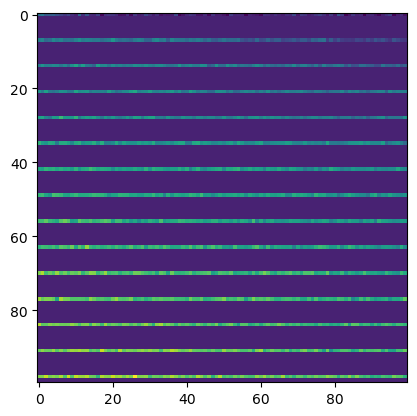

In [44]:
plt.imshow(backproj[:100,:100])
plt.show()

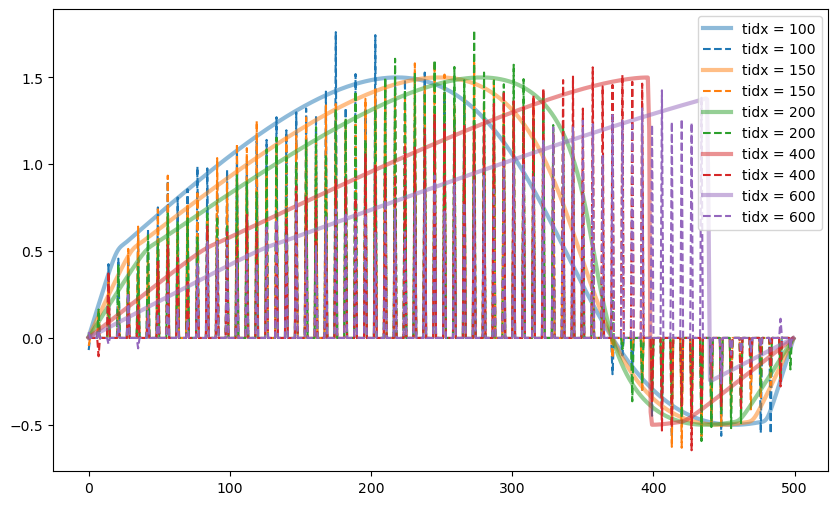

In [36]:
inspect_time_idxs = [100, 150, 200, 400, 600] # indices to inspect solution at

plt.figure(figsize=(10,6))
for j, t in enumerate(inspect_time_idxs):
    plt.plot(burgers_data[:,t], label=f"tidx = {t}", color=f"C{j}", ls="-", alpha=0.5, lw=3)
    plt.plot(backproj[:,t], label=f"tidx = {t}", color=f"C{j}", ls="--")

plt.legend()
plt.show()

# GKS with joint spatiotemporal data

In [37]:
from hybridpro import HybridProjectionIRLSSolver

In [57]:
# Solution by GKS
solver = HybridProjectionIRLSSolver(A, aslinearoperator(L), b, noise_var=noise_var)
joint_data = solver.solve(n_iters=25, regparam="dp", xtrue=xtrue, x0=None, gen_plots=False, out_dir="joint_spatiotemporal_dp")
joint_data = solver.solve(n_iters=25, regparam="lcurve", xtrue=xtrue, x0=None, gen_plots=False, out_dir="joint_spatiotemporal_lcurve")

KeyboardInterrupt: 

In [39]:
recon = joint_data["x"].reshape(grid_shape)
joint_data.keys()

dict_keys(['x', 'w', 'z', 'proj_basis', 'lambdah', 'rel_errs', 'lambdahs', 'V', 'AV', 'LV', 'WLV', 'x_under', 'b_under', 'd_under', 'A_matvecs', 'L_matvecs', 'completed_iterations', 'tot_calc_time', 'projected_condition_numbers', 'restarting', 'restart_dim'])

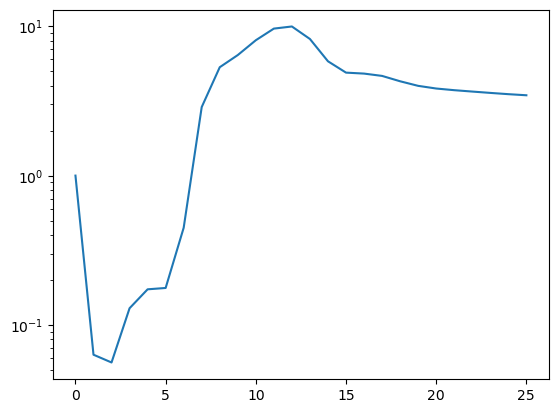

In [40]:
plt.semilogy(joint_data["lambdahs"])
plt.show()

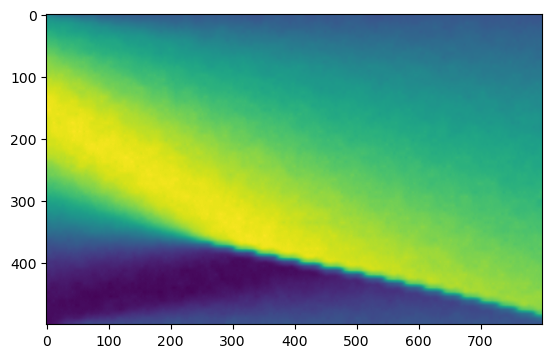

In [41]:
plt.imshow(recon)
plt.show()

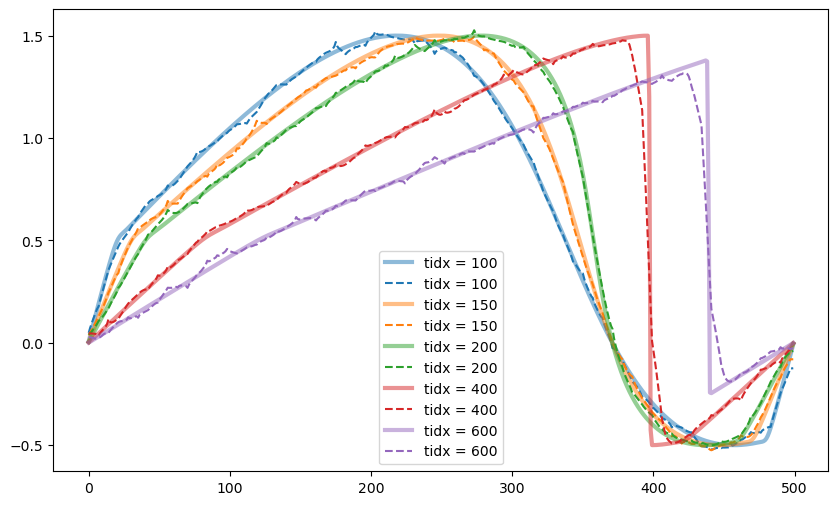

In [42]:
inspect_time_idxs = [100, 150, 200, 400, 600] # indices to inspect solution at

plt.figure(figsize=(10,6))
for j, t in enumerate(inspect_time_idxs):
    plt.plot(burgers_data[:,t], label=f"tidx = {t}", color=f"C{j}", ls="-", alpha=0.5, lw=3)
    plt.plot(recon[:,t], label=f"tidx = {t}", color=f"C{j}", ls="--")

plt.legend()
plt.show()

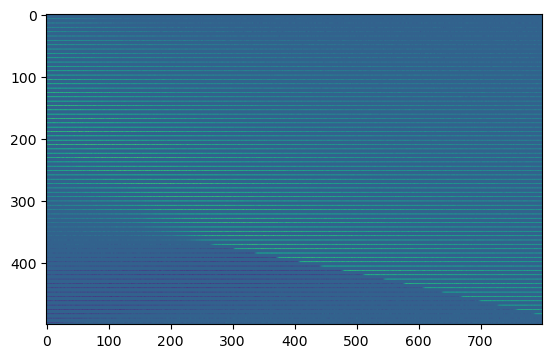

In [55]:
plt.imshow( joint_data["V"][:,0].reshape(grid_shape) )
plt.show()

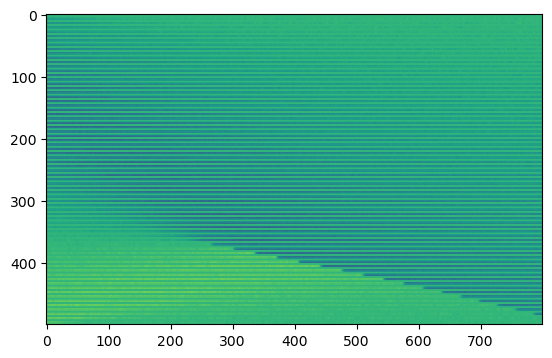

In [50]:
plt.imshow( joint_data["V"][:,1].reshape(grid_shape) )
plt.show()

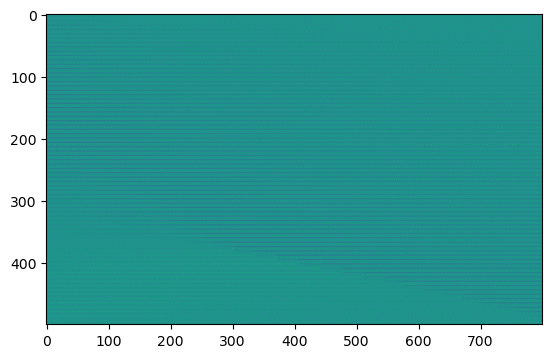

In [53]:
plt.imshow( joint_data["V"][:,5].reshape(grid_shape) )
plt.show()